<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

fatal: destination path 'DDM-Project-WS24-25' already exists and is not an empty directory.


In [ ]:
!pip install -q hdbscan

In [ ]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import hdbscan
import cv2
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab.patches import cv2_imshow

# Loading the Data

In [ ]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [ ]:
df_gdp = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Cleaning the data

In [ ]:
def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

In [ ]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [ ]:
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


# Industries

## Filtering & Aggregating the industries with most establishments per FIPS

In [ ]:
df_pattern.head()

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,N
4,01,001,01001,23,2362,Nonresidential Building Construction,H,69,H,685,...,N,N,N,N,N,N,N,N,N,N
5,01,001,01001,23,2371,Utility System Construction,H,65,H,1117,...,N,N,N,N,N,N,N,N,N,N


In [ ]:
df_pattern_agg = df_pattern.groupby(['naics', 'DESCRIPTION']).agg({
    'emp': 'sum',
    'est': 'sum',
    'FIPS': 'nunique' # mit in Gewichtung
}).reset_index()

df_pattern_agg = df_pattern_agg.sort_values(by=['est', 'emp'], ascending=False)

df_pattern_agg.head(40)

,naics,DESCRIPTION,emp,est,FIPS
65,5617,Services to Buildings and Dwellings,2004960,220492,2530
13,2382,Building Equipment Contractors,2171001,193562,2756
67,8111,Automotive Repair and Maintenance,902870,164584,2725
14,2383,Building Finishing Contractors,811812,124074,2040
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427
64,5613,Employment Services,7061425,57057,1306
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947


In [ ]:
# Eindeutige Kombinationen extrahieren
unique_combinations = df_pattern_agg[['naics', 'DESCRIPTION']].drop_duplicates()

# Alle Kombinationen drucken
for index, row in unique_combinations.iterrows():
    print(f"NAICS: {row['naics']}, DESCRIPTION: {row['DESCRIPTION']}")


NAICS: 5617, DESCRIPTION: Services to Buildings and Dwellings
NAICS: 2382, DESCRIPTION: Building Equipment Contractors
NAICS: 8111, DESCRIPTION: Automotive Repair and Maintenance
NAICS: 2383, DESCRIPTION: Building Finishing Contractors
NAICS: 5413, DESCRIPTION: Architectural, Engineering, and Related Services
NAICS: 2381, DESCRIPTION: Foundation, Structure, and Building Exterior Contractors
NAICS: 7139, DESCRIPTION: Other Amusement and Recreation Industries
NAICS: 4413, DESCRIPTION: Automotive Parts, Accessories, and Tire Stores
NAICS: 5613, DESCRIPTION: Employment Services
NAICS: 4238, DESCRIPTION: Machinery, Equipment, and Supplies Merchant Wholesalers
NAICS: 4411, DESCRIPTION: Automobile Dealers
NAICS: 2362, DESCRIPTION: Nonresidential Building Construction
NAICS: 4231, DESCRIPTION: Motor Vehicle and Motor Vehicle Parts and Supplies Merchant Wholesalers
NAICS: 3231, DESCRIPTION: Printing and Related Support Activities
NAICS: 3327, DESCRIPTION: Machine Shops; Turned Product; and Scre

## Ranking the Industries

In [ ]:
tool_consumption_ranking_industries = {
    "3311": 1,  # Iron and Steel Mills and Ferroalloy Manufacturing
    "3327": 1,  # Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing

    "3320A1": 2, # Fabricated Metal Product Manufacturing
    "3320A2": 2, # Metalworking Machinery Manufacturing
    "3335": 2,   # Metalworking Machinery Manufacturing

    "3312": 3,   # Steel Product Manufacturing from Purchased Steel
    "3313": 3,   # Alumina and Aluminum Production and Processing
    "3314": 3,   # Nonferrous Metal (except Aluminum) Production and Processing
    "3315": 3,   # Foundries
    "3363": 3,   # Motor Vehicle Parts Manufacturing
    "3336": 3,   # Engine, Turbine, and Power Transmission Equipment Manufacturing

    "3330A1": 4, # Machinery Manufacturing
    "3333": 4,   # Commercial and Service Industry Machinery Manufacturing
    "3364": 4,   # Aerospace Product and Parts Manufacturing
    "3365": 4,   # Railroad Rolling Stock Manufacturing
    "3366": 4,   # Ship and Boat Building
    "2122": 4,   # Metal Ore Mining

    "2381": 5,   # Foundation, Structure, and Building Exterior Contractors
    "2383": 5,   # Building Finishing Contractors
    "2121": 5,   # Coal Mining
    "2123": 5,   # Nonmetallic Mineral Mining and Quarrying
    "2131": 5,   # Support Activities for Mining

    "2371": 6,   # Utility System Construction
    "2373": 6,   # Highway, Street, and Bridge Construction
    "2379": 6,   # Other Heavy and Civil Engineering Construction
    "3241": 6,   # Petroleum and Coal Products Manufacturing
    "3361": 6,   # Motor Vehicle Manufacturing
    "3362": 6,   # Motor Vehicle Body and Trailer Manufacturing
    "3370A1": 6, # Furniture Manufacturing
    "3391": 6,   # Medical Equipment and Supplies Manufacturing
    "3399": 6,   # Other Miscellaneous Manufacturing

    "2111": 7,   # Oil and Gas Extraction
    "2362": 7,   # Nonresidential Building Construction
    "2382": 7,   # Building Equipment Contractors
    "3119": 7,   # Other Food Manufacturing
    "3211": 7,   # Sawmills and Wood Preservation
    "3250A1": 7, # Chemical Manufacturing (3251, 3252, 3253, 3259)
    "3261": 7,   # Plastics Product Manufacturing
    "3262": 7,   # Rubber Product Manufacturing
    "4413": 7,   # Automotive Parts, Accessories, and Tire Stores
    "4811": 7,   # Scheduled Air Transportation
    "4812": 7,   # Nonscheduled Air Transportation
    "4861": 7,   # Pipeline Transportation of Crude Oil
    "4862": 7,   # Pipeline Transportation of Natural Gas
    "4881": 7,   # Support Activities for Air Transportation
    "4882": 7,   # Support Activities for Rail Transportation
    "8111": 7,   # Automotive Repair and Maintenance
    "8113": 7,   # Commercial and Industrial Machinery Repair and Maintenance

    "1133": 8,   # Logging
    "2211": 8,   # Electric Power Generation, Transmission and Distribution
    "2212": 8,   # Natural Gas Distribution
    "3212": 8,   # Veneer, Plywood, and Engineered Wood Product Manufacturing
    "3219": 8,   # Other Wood Product Manufacturing
    "3231": 8,   # Printing and Related Support Activities
    "4411": 8,   # Automobile Dealers

    "4412": 9,   # Other Motor Vehicle Dealers
    "5413": 9,   # Architectural, Engineering, and Related Services
    "5612": 9,   # Facilities Support Services
    "5617": 9,   # Services to Buildings and Dwellings

    "3132": 10,  # Fabric Mills
    "7139": 10,  # Other Amusement and Recreation Industries
    "5613": 10   # Employment Services
}


In [ ]:
def get_ranking(naics_code):
    # Konvertiert den NAICS-Code in einen String und prüft auf vollständige Übereinstimmung
    return tool_consumption_ranking_industries.get(str(naics_code), None)

# Anwendung der Funktion auf die Spalte 'naics' im DataFrame
df_pattern_agg['tool_consumption_ranking'] = (
    df_pattern_agg['naics']
    .apply(get_ranking)
)

# Die Top-10-Industrien basierend auf dem Ranking auswählen
df_top_industries = (
    df_pattern_agg.sort_values(by='tool_consumption_ranking', ascending=True)
    .head(10)
)

# Ausgabe oder weitere Verarbeitung
df_top_industries

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking
26,3311,Iron and Steel Mills and Ferroalloy Manufacturing,44071,152,34,1.0
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",332653,20979,1276,1.0
37,3335,Metalworking Machinery Manufacturing,117724,5141,455,2.0
31,3320A1,"3321, 3322, 3325, 3326, 3329",315026,7798,592,2.0
32,3320A2,"3323, 3323",343891,12558,1057,2.0
28,3313,Alumina and Aluminum Production and Processing,20149,147,36,3.0
27,3312,Steel Product Manufacturing from Purchased Steel,21490,282,54,3.0
38,3336,"Engine, Turbine, and Power Transmission Equipm...",46179,430,81,3.0
29,3314,Nonferrous Metal (except Aluminum) Production ...,25202,436,82,3.0
30,3315,Foundries,56860,836,146,3.0


In [ ]:
df_top_industries['tool_consumption_ranking'].isna().sum()

0

In [ ]:
df_top_industries['rank_est'] = pd.qcut(
    df_top_industries['est'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

df_top_industries['rank_emp'] = pd.qcut(
    df_top_industries['emp'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

In [ ]:
df_top_industries.head()

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking,rank_est,rank_emp
26,3311,Iron and Steel Mills and Ferroalloy Manufacturing,44071,152,34,1.0,9,7
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",332653,20979,1276,1.0,1,2
37,3335,Metalworking Machinery Manufacturing,117724,5141,455,2.0,4,4
31,3320A1,"3321, 3322, 3325, 3326, 3329",315026,7798,592,2.0,3,3
32,3320A2,"3323, 3323",343891,12558,1057,2.0,2,1


In [ ]:
# changing the description
df_top_industries.loc[df_top_industries['naics'] == '3320A2', 'DESCRIPTION'] = 'Metalworking Machinery Manufacturing'
df_top_industries.loc[df_top_industries['naics'] == '3320A1', 'DESCRIPTION'] = 'Fabricated Metal Product Manufacturing'

# anzahl der unique counties hinzufügen

In [ ]:
weight_tool_consumption = 0.5
weight_emp = 0.3
weight_est = 0.2

df_top_industries['weighted_rank'] = (
    df_top_industries['tool_consumption_ranking'].astype(float) * weight_tool_consumption +
    df_top_industries['rank_emp'].astype(float) * weight_emp +
    df_top_industries['rank_est'].astype(float) * weight_est
)

df_top_industries_sorted = df_top_industries.sort_values(by='weighted_rank')
df_top_industries_sorted.head()

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking,rank_est,rank_emp,weighted_rank
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",332653,20979,1276,1.0,1,2,1.3
32,3320A2,Metalworking Machinery Manufacturing,343891,12558,1057,2.0,2,1,1.7
31,3320A1,Fabricated Metal Product Manufacturing,315026,7798,592,2.0,3,3,2.5
37,3335,Metalworking Machinery Manufacturing,117724,5141,455,2.0,4,4,3.0
30,3315,Foundries,56860,836,146,3.0,5,5,4.0


In [ ]:
top_5_naics = df_top_industries.sort_values(by='weighted_rank').head(5)['naics'].tolist()
top_5_naics

['3327', '3320A2', '3320A1', '3335', '3315']

# Filtering the FIPS with the highest amount of Top Industries


In [ ]:
df_naics_feature = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for naics_code in top_5_naics:
    est_values = df_pattern[df_pattern['naics'] == naics_code].groupby('FIPS')['est'].sum().reset_index()
    est_values.rename(columns={'est': f'est_{naics_code}'}, inplace=True)
    df_naics_feature = df_naics_feature.merge(est_values, on='FIPS', how='left')

df_naics_feature.fillna(0, inplace=True)

df_naics_feature.rename(columns={f'est_{naics}': f'est_{naics}' for naics in top_5_naics}, inplace=True)

df_naics_feature.head()

,FIPS,est_3327,est_3320A2,est_3320A1,est_3335,est_3315
0,01001,0.0,0.0,0.0,0.0,0.0
1,01003,10.0,16.0,5.0,0.0,0.0
2,01005,0.0,0.0,0.0,0.0,0.0
3,01007,3.0,0.0,0.0,0.0,0.0
4,01009,7.0,6.0,0.0,0.0,0.0


In [ ]:
len(df_naics_feature)

3071

# Occupations

In [ ]:
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


# alle occupations ranken

In [ ]:
tool_consumption_ranking_occ = {
    "00-0000": 10,  # All Occupations (broadest, general low need)
    "11-0000": 9,   # Management Occupations (low tool demand, focus on strategy)
    "13-0000": 8,   # Business and Financial Operations Occupations (tools like software)
    "15-0000": 3,   # Computer and Mathematical Occupations (high need for software tools)
    "17-0000": 3,   # Architecture and Engineering Occupations (high need for specialized tools)
    "19-0000": 6,   # Life, Physical, and Social Science Occupations (moderate tool need)
    "21-0000": 8,   # Community and Social Service Occupations (lower tool need)
    "23-0000": 7,   # Legal Occupations (moderate software/tool use)
    "25-0000": 9,   # Educational Instruction and Library Occupations (minimal tool demand)
    "27-0000": 6,   # Arts, Design, Entertainment, Sports, and Media Occupations (varied tool needs)
    "29-0000": 5,   # Healthcare Practitioners and Technical Occupations (specialized medical tools)
    "31-0000": 6,   # Healthcare Support Occupations (moderate tool use)
    "33-0000": 7,   # Protective Service Occupations (tools for safety and security)
    "35-0000": 10,  # Food Preparation and Serving Related Occupations (basic tool needs)
    "37-0000": 2,   # Building and Grounds Cleaning and Maintenance Occupations (simple tools)
    "39-0000": 9,   # Personal Care and Service Occupations (low specialized tool demand)
    "41-0000": 8,   # Sales and Related Occupations (low to moderate tool demand)
    "43-0000": 8,   # Office and Administrative Support Occupations (basic office tools)
    "45-0000": 3,   # Farming, Fishing, and Forestry Occupations (moderate traditional tool use)
    "47-0000": 1,   # Construction and Extraction Occupations (high demand for physical tools)
    "49-0000": 2,   # Installation, Maintenance, and Repair Occupations (tool-intensive)
    "51-0000": 1,   # Production Occupations (specialized machinery/tools)
    "53-0000": 3    # Transportation and Material Moving Occupations (moderate tool use)
}

In [ ]:
def get_ranking_occ(occ_code):
    occ_prefix = occ_code[:2]
    return tool_consumption_ranking_occ.get(occ_prefix + "-0000", None)

df_occupation['rank_tool_consumption'] = df_occupation['OCC_CODE'].apply(get_ranking_occ)

df_occupation_agg = (
    df_occupation.groupby(['OCC_TITLE', 'OCC_CODE'])
    .agg(
        emp_occupation=(
        'emp_occupation', 'sum'
        ),
        rank_tool_consumption=(
        'rank_tool_consumption', 'first'
        ))
    .reset_index()
)

df_occupation_agg = df_occupation_agg.sort_values(by='rank_tool_consumption').reset_index(drop=True)

df_occupation_agg.head()

,OCC_TITLE,OCC_CODE,emp_occupation,rank_tool_consumption
0,"Woodworking Machine Setters, Operators, and Te...",51-7042,59929.120248,1
1,"Heat Treating Equipment Setters, Operators, an...",51-4191,14373.840597,1
2,Structural Iron and Steel Workers,47-2221,62314.386696,1
3,Sheet Metal Workers,47-2211,117498.787647,1
4,"Service Unit Operators, Oil and Gas",47-5013,34539.002110,1


In [ ]:
df_occupation_agg['rank_emp'] = pd.qcut(
    df_occupation_agg['emp_occupation'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

df_occupation_agg = df_occupation_agg.sort_values(by=['rank_tool_consumption', 'rank_emp']).reset_index(drop=True)

df_occupation_agg.head(5)

,OCC_TITLE,OCC_CODE,emp_occupation,rank_tool_consumption,rank_emp
0,Machinists,51-4041,287763.569434,1,1
1,"Welders, Cutters, Solderers, and Brazers",51-4121,359511.557130,1,1
2,"Cutting, Punching, and Press Machine Setters, ...",51-4031,165860.452744,1,1
3,Sheet Metal Workers,47-2211,117498.787647,1,2
4,"Grinding, Lapping, Polishing, and Buffing Mach...",51-4033,71782.245337,1,2


In [ ]:
top_occupations = df_occupation_agg.head(5)['OCC_CODE'].tolist()
top_occupations

['51-4041', '51-4121', '51-4031', '47-2211', '51-4033']

In [ ]:
df_occ_features = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for occ_code in top_occupations:
    occ_values = (
        df_occupation[df_occupation['OCC_CODE'] == occ_code]
        .groupby('FIPS')['emp_occupation']
        .sum()
        .reset_index()
    )
    occ_values.rename(columns={'emp_occupation': f'emp_occ_{occ_code}'}, inplace=True)
    df_occ_features = df_occ_features.merge(occ_values, on='FIPS', how='left')

df_occ_features.fillna(0, inplace=True)

df_occ_features.rename(columns={f'emp_occ_{occ}': f'emp_occ_{occ}' for occ in top_occupations}, inplace=True)

df_occ_features.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646


In [ ]:
len(df_occ_features)

3071

# GDP Data

In [ ]:
df_gdp.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022
0,0,United States,,CAGDP9,1,...,All industry total,Thousands of chained 2017 dollars,1.961210e+10,2.019390e+10,2.069209e+10,2.023407e+10,2.140769e+10,2.182204e+10
1,0,United States,,CAGDP9,2,...,Private industries,Thousands of chained 2017 dollars,1.715626e+10,1.771178e+10,1.819575e+10,1.776187e+10,1.890945e+10,1.928312e+10
2,0,United States,,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,1.768400e+08,1.841050e+08,1.711490e+08,1.736590e+08,1.837420e+08,1.700580e+08
3,0,United States,,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,2.673020e+08,2.770130e+08,3.146040e+08,3.055880e+08,2.694780e+08,2.452900e+08
4,0,United States,,CAGDP9,10,22,Utilities,Thousands of chained 2017 dollars,3.137110e+08,3.092690e+08,3.129200e+08,3.323360e+08,3.166030e+08,3.183920e+08


In [ ]:
df_gdp['FIPS'] = df_gdp['FIPS'].astype(str)

df_gdp = df_gdp[(df_gdp['FIPS'].astype(str).str.len() == 5) | (df_gdp['FIPS'].astype(str).str.len() == 4)]

df_gdp['FIPS'] = df_gdp['FIPS'].apply(add_zeros)

df_gdp_agg = df_gdp.groupby('FIPS').agg(
    gdp=('2022', 'sum')
).reset_index()

df_gdp_agg.head()

<ipython-input-112-98d16d2d40c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gdp['FIPS'] = df_gdp['FIPS'].apply(add_zeros)


,FIPS,gdp
0,01000,1.091017e+09
1,01001,8.923713e+06
2,01003,4.162898e+07
3,01005,3.171057e+06
4,01007,1.752416e+06


In [ ]:
len(df_gdp_agg)

3177

In [ ]:
df_gdp['FIPS'].unique()

array(['01000', '01001', '01003', ..., '96000', '97000', '98000'],
      dtype=object)

# Final DataFrame

In [ ]:
df_merged = pd.merge(df_occ_features, df_naics_feature, on='FIPS', how='inner')
df_merged.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036,10.0,16.0,5.0,0.0,0.0
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266,3.0,0.0,0.0,0.0,0.0
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646,7.0,6.0,0.0,0.0,0.0


In [ ]:
df_merged = pd.merge(df_merged, df_gdp_agg, on='FIPS', how='left')
df_merged.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0,8923713.0
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036,10.0,16.0,5.0,0.0,0.0,41628984.0
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0,3171057.0
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266,3.0,0.0,0.0,0.0,0.0,1752416.0
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646,7.0,6.0,0.0,0.0,0.0,4165379.0


# Data Preprocessing

In [ ]:
df_final = df_merged.copy()

In [ ]:
df_final.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0,8923713.0
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036,10.0,16.0,5.0,0.0,0.0,41628984.0
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0,3171057.0
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266,3.0,0.0,0.0,0.0,0.0,1752416.0
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646,7.0,6.0,0.0,0.0,0.0,4165379.0


In [ ]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

## Log 10 Scaled

In [ ]:
X = df_final.drop(columns=['FIPS'])
X_log_scaled = np.log10(X + 1)
X_log_scaled = pd.DataFrame(X_log_scaled, columns=X.columns)

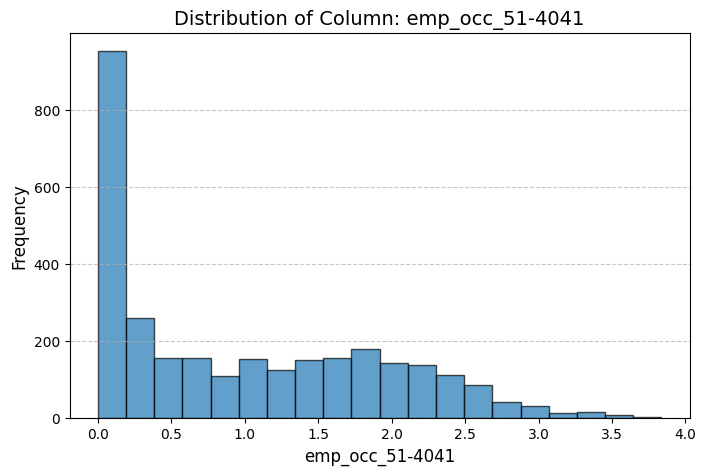

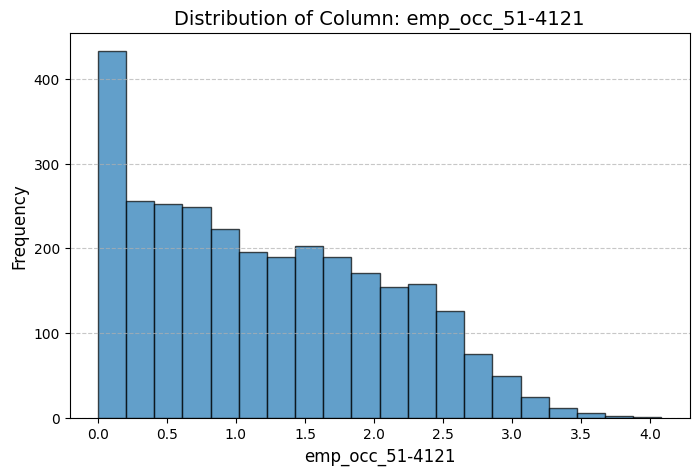

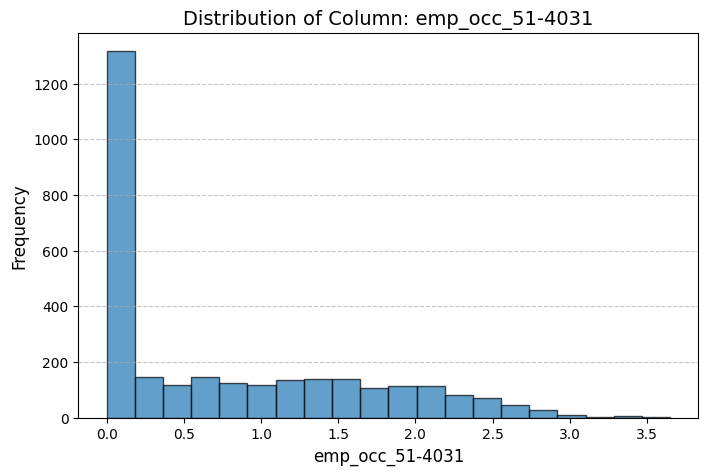

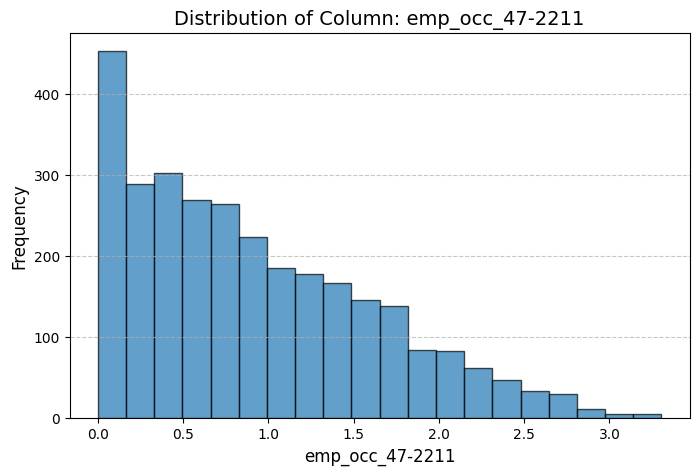

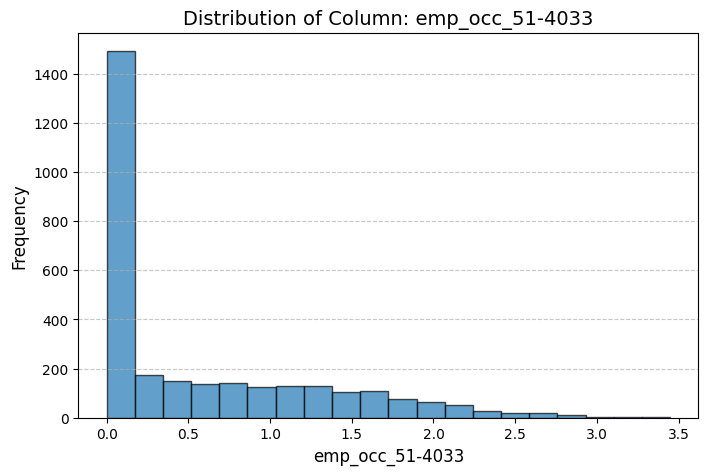

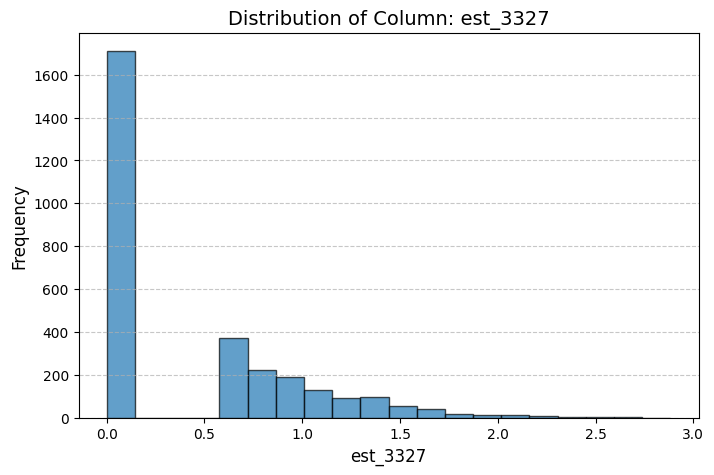

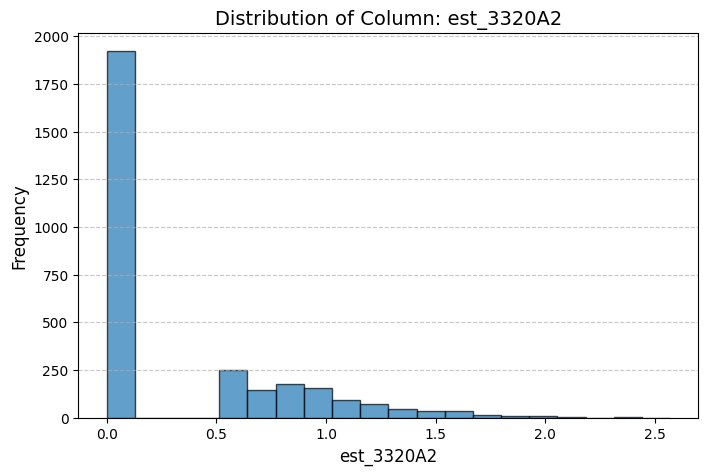

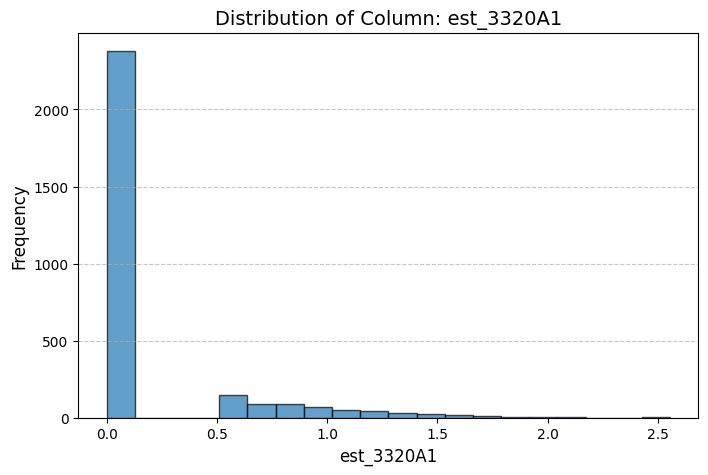

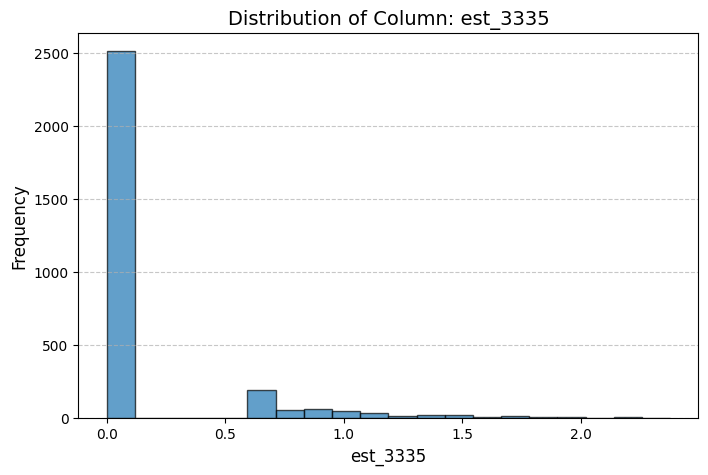

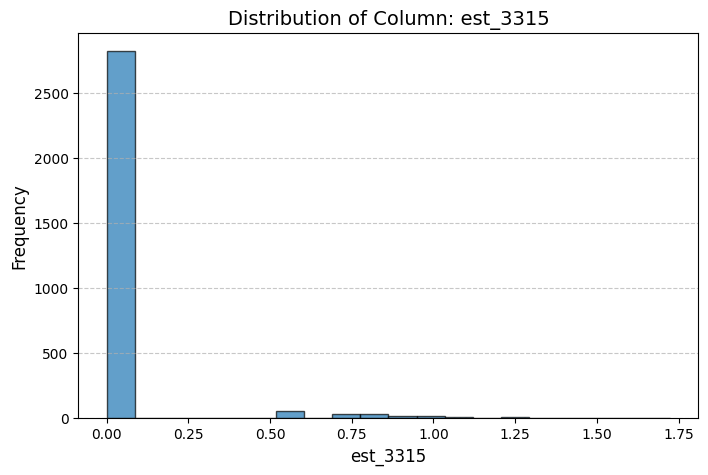

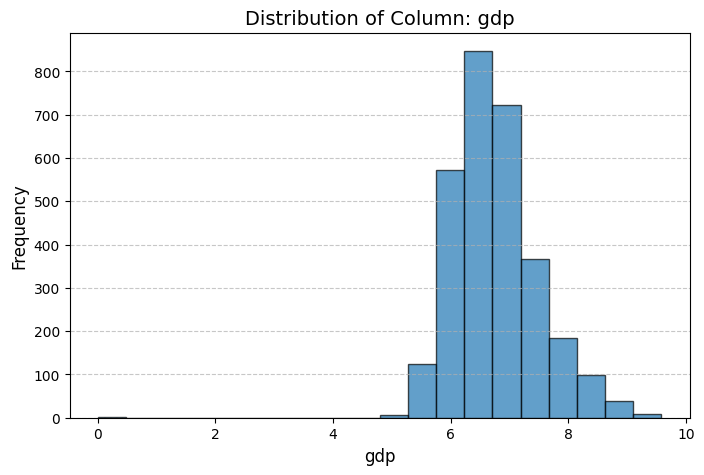

In [ ]:
for column in X_log_scaled.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(X_log_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Column: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Standard Scaled

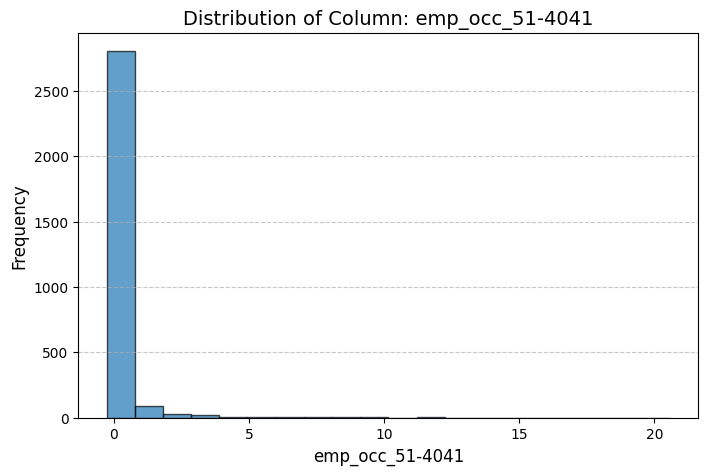

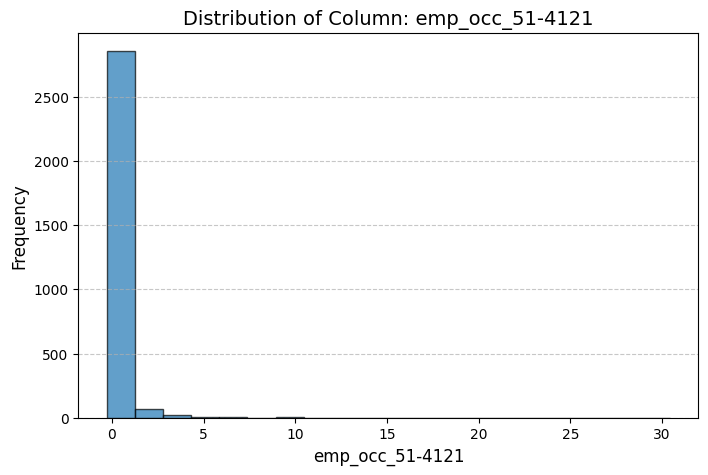

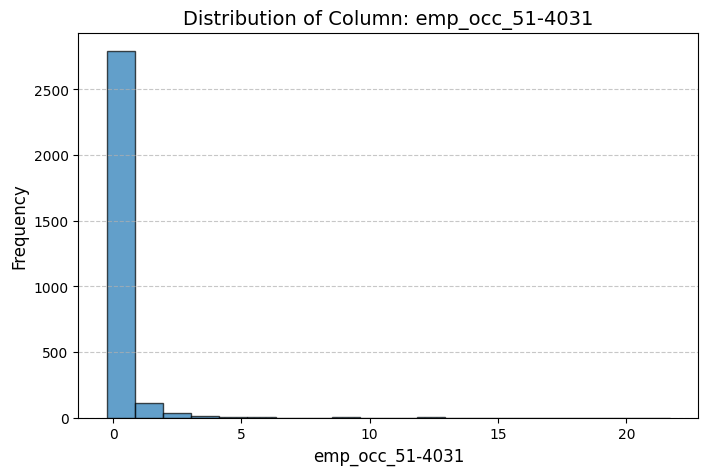

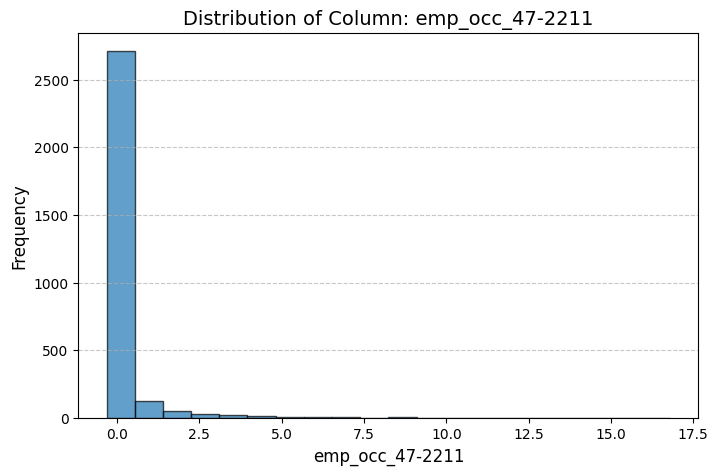

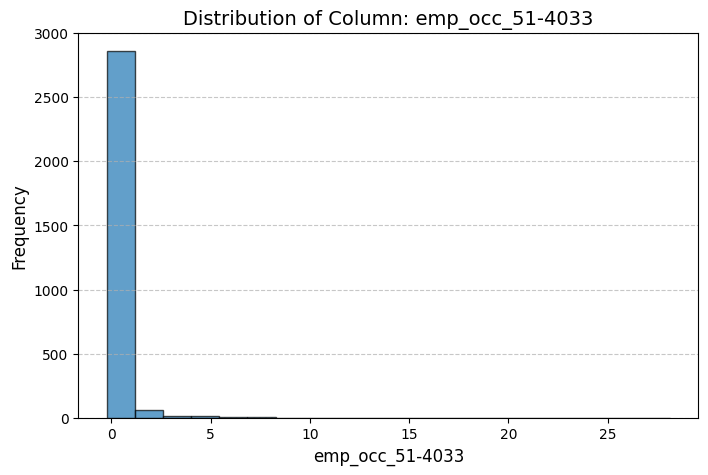

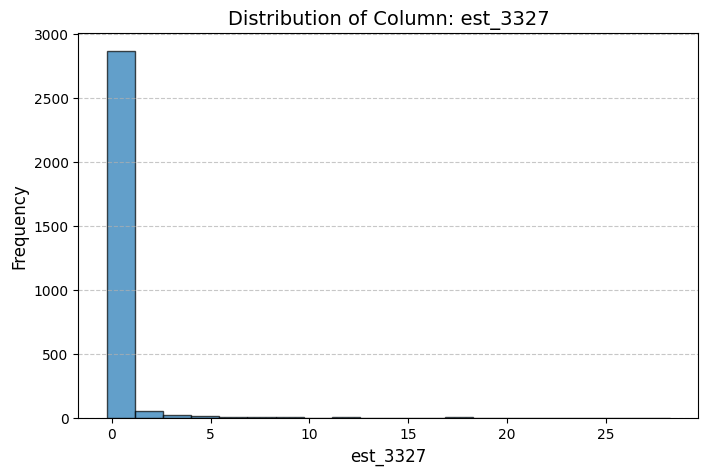

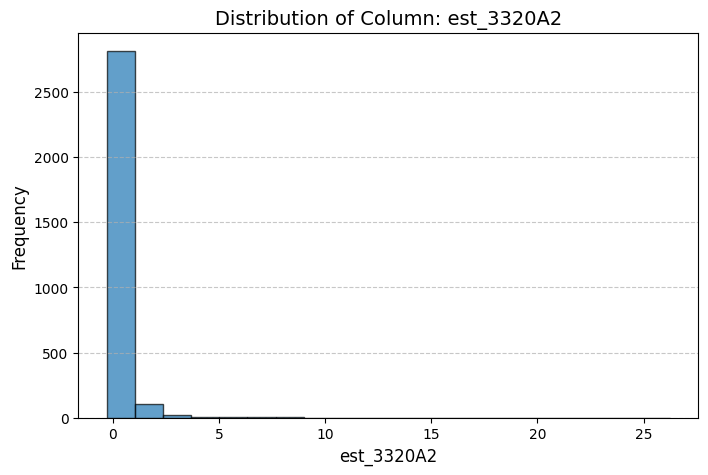

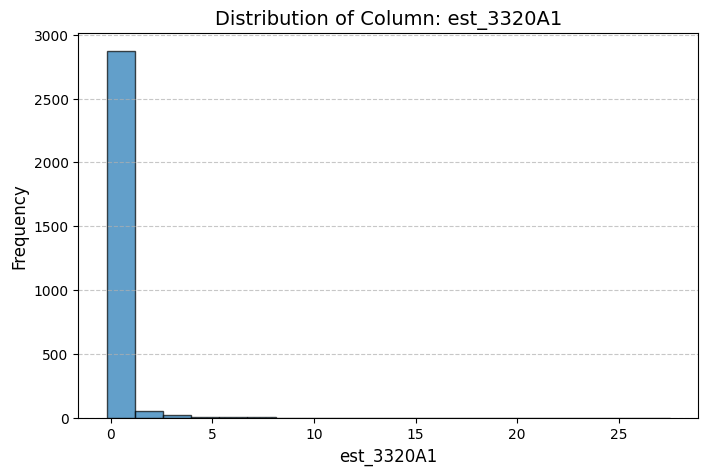

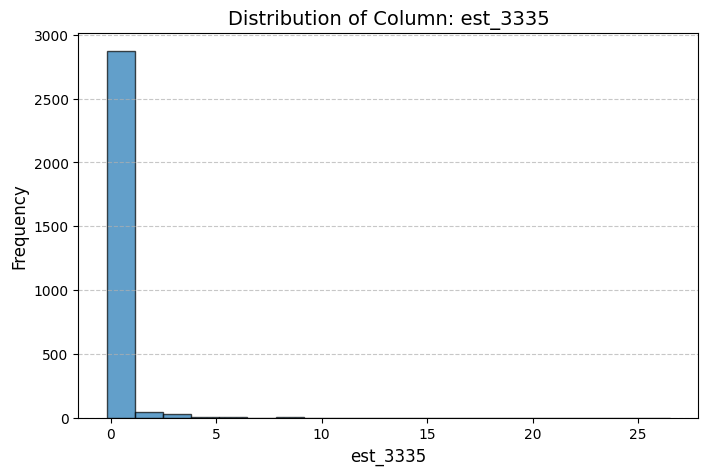

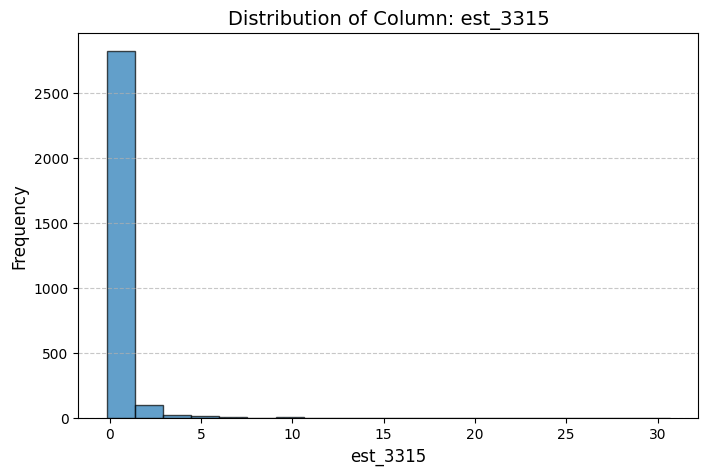

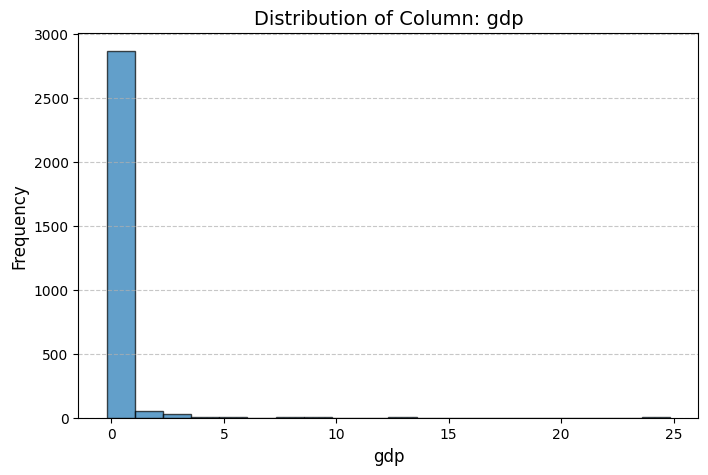

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df_final.drop(columns=['FIPS'])
scaler = StandardScaler()
X_standard_scaled = scaler.fit_transform(X)

X_standard_scaled = pd.DataFrame(X_standard_scaled, columns=X.columns)

for column in X_standard_scaled.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(X_standard_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Column: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# PCA

In [ ]:
X_log_scaled.head()

,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp
0,0.212366,0.939699,0.041232,0.904370,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.950546
1,2.133765,2.289062,1.874662,1.872089,1.619991,1.041393,1.230449,0.778151,0.0,0.0,7.619396
2,0.866108,0.926484,1.000571,0.335175,0.499439,0.000000,0.000000,0.000000,0.0,0.0,6.501204
3,0.863721,0.989644,0.221141,1.335744,0.273988,0.602060,0.000000,0.000000,0.0,0.0,6.243637
4,1.396405,1.588498,1.023018,1.168875,0.793486,0.903090,0.845098,0.000000,0.0,0.0,6.619655


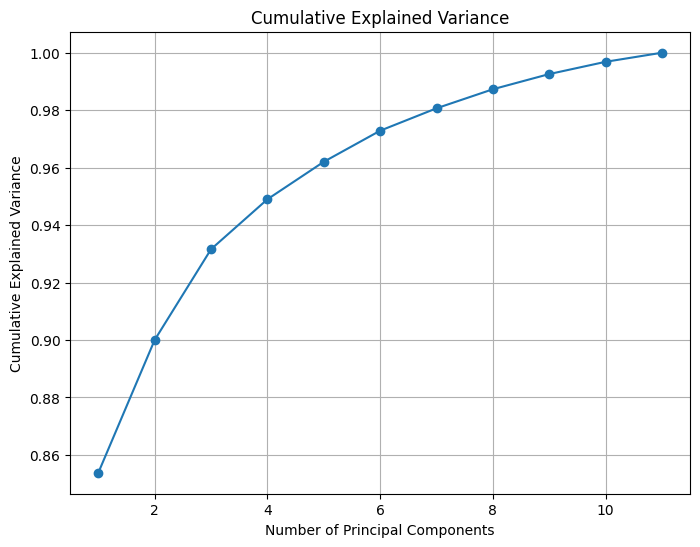

Number of components explaining 90% variance: 2


In [ ]:
pca = PCA()
X_pca_log = pca.fit_transform(X_log_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'Number of components explaining 90% variance: {n_components}')


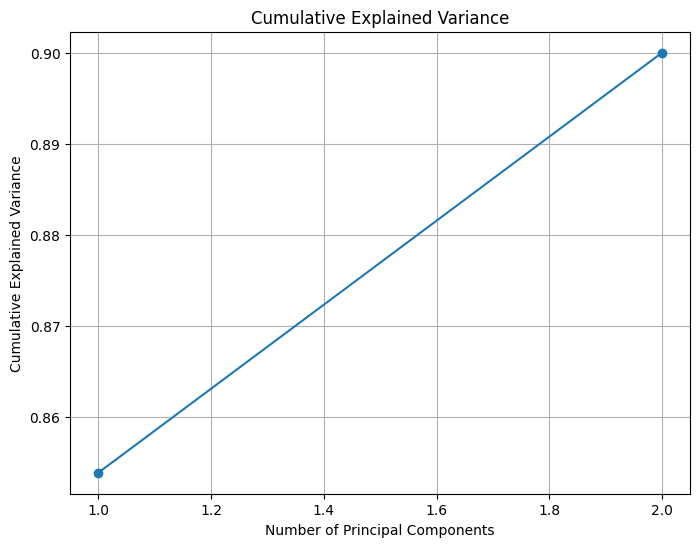

Number of components explaining 90% variance: 2


In [ ]:
pca = PCA(n_components=n_components)
X_pca_standard_scaled = pca.fit_transform(X_log_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'Number of components explaining 90% variance: {n_components}')


# Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


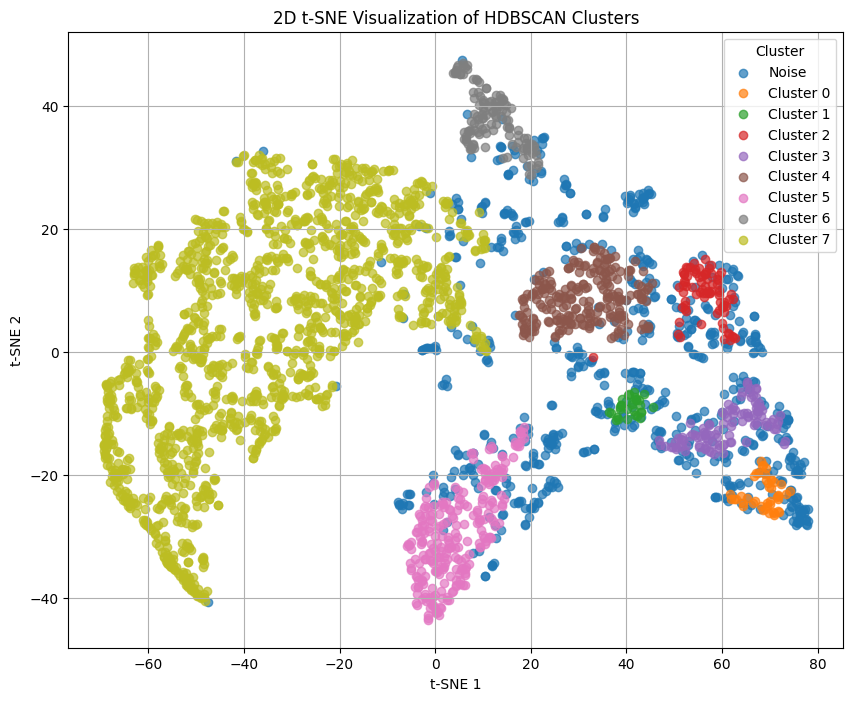

In [ ]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=15)
clusters = hdbscan_clusterer.fit_predict(X_log_scaled)
df_final['cluster'] = clusters
X_tsne_2d = TSNE(n_components=2, random_state=1, perplexity=30).fit_transform(X_log_scaled)
plt.figure(figsize=(10, 8))
for c in np.unique(clusters):
    i = clusters == c
    l = 'Noise' if c == -1 else f'Cluster {c}'
    plt.scatter(X_tsne_2d[i, 0], X_tsne_2d[i, 1], label=l, alpha=0.7)
plt.title('2D t-SNE Visualization of HDBSCAN Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [ ]:
df_final['cluster'].unique()

array([ 7,  2,  5,  4, -1,  6,  3,  0,  1])

# Cluster Interpretation

In [ ]:
df_final.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp,cluster
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0,8923713.0,7
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036,10.0,16.0,5.0,0.0,0.0,41628984.0,2
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0,3171057.0,7
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266,3.0,0.0,0.0,0.0,0.0,1752416.0,5
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646,7.0,6.0,0.0,0.0,0.0,4165379.0,4


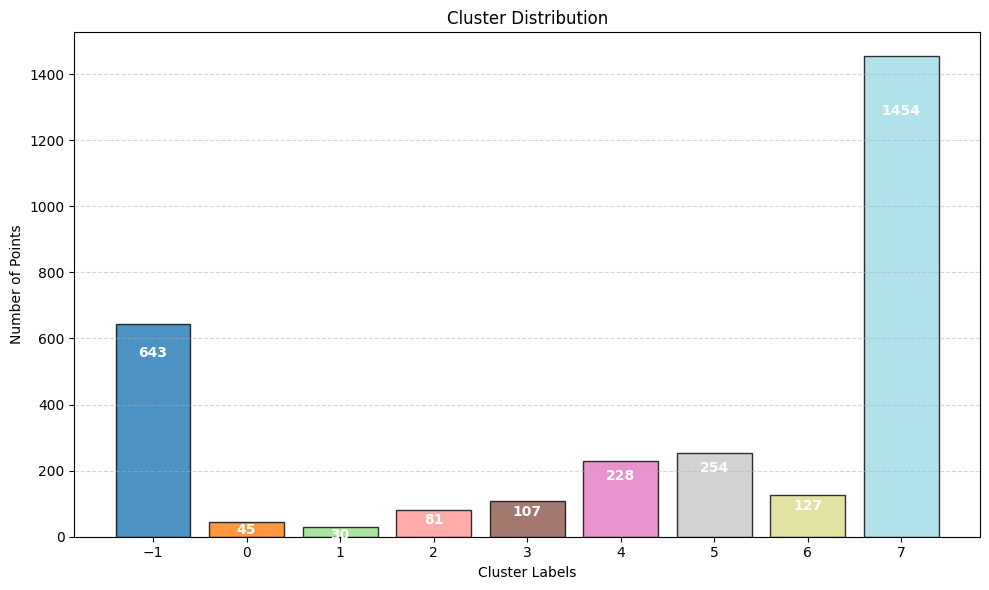

In [ ]:
cluster_counts = df_final['cluster'].value_counts().sort_index()
unique_clusters = cluster_counts.index
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(10, 6))

bars = plt.bar(
    unique_clusters,
    cluster_counts,
    color=colors,
    edgecolor='black',
    alpha=0.8
)

for bar, count in zip(bars, cluster_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - (bar.get_height() * 0.1),
        f'{count}',
        ha='center',
        va='top',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

plt.title('Cluster Distribution')
plt.xlabel('Cluster Labels')
plt.ylabel('Number of Points')
plt.xticks(unique_clusters)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
df_final.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp,cluster
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0,8923713.0,7
1,01003,135.070777,193.563643,73.931112,73.488520,40.686036,10.0,16.0,5.0,0.0,0.0,41628984.0,2
2,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0,3171057.0,7
3,01007,6.306702,8.764359,0.663953,20.664265,0.879266,3.0,0.0,0.0,0.0,0.0,1752416.0,5
4,01009,23.911795,37.770212,9.544317,13.752811,5.215646,7.0,6.0,0.0,0.0,0.0,4165379.0,4


In [ ]:
cluster_summary = (
    df_final.groupby('cluster')
    .agg(
        count=('FIPS', 'size'),
        avg_est_5617=('est_3327', 'mean'),
        avg_est_2382=('est_3320A2', 'mean'),
        avg_est_8111=('est_3320A1', 'mean'),
        avg_est_5413=('est_3335', 'mean'),
        avg_est_7139=('est_3315', 'mean'),
        avg_emp_occ_51_4121=('emp_occ_51-4041', 'mean'),
        avg_emp_occ_51_4041=('emp_occ_51-4121', 'mean'),
        avg_emp_occ_51_4031=('emp_occ_51-4031', 'mean'),
        avg_emp_occ_47_2211=('emp_occ_47-2211', 'mean'),
        avg_emp_occ_51_4072=('emp_occ_51-4033', 'mean')
    )
    .reset_index()
)


cluster_summary.sort_values(by='count', ascending=False, inplace=True)

cluster_summary.head()

,cluster,count,avg_est_5617,avg_est_2382,avg_est_8111,avg_est_5413,avg_est_7139,avg_emp_occ_51_4121,avg_emp_occ_51_4041,avg_emp_occ_51_4031,avg_emp_occ_47_2211,avg_emp_occ_51_4072
8,7,1454,0.000000,0.000000,0.00000,0.000000,0.000000,1.307243,5.115566,1.032244,2.449726,0.195169
0,-1,643,19.839813,11.463453,8.51944,5.603421,0.953344,281.659850,346.960065,160.969381,112.226046,73.799253
6,5,254,4.236220,0.000000,0.00000,0.000000,0.000000,23.909120,18.032983,10.240886,6.360278,3.213909
5,4,228,5.885965,5.271930,0.00000,0.000000,0.000000,44.395718,88.143940,29.477494,30.620142,8.411719
7,6,127,0.000000,3.653543,0.00000,0.000000,0.000000,5.646702,36.580421,8.220221,13.632860,1.665645


In [ ]:
df_result = df_final[(df_final['cluster'] == 7)].reset_index(drop=True)
df_result.head()

,FIPS,emp_occ_51-4041,emp_occ_51-4121,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4033,est_3327,est_3320A2,est_3320A1,est_3335,est_3315,gdp,cluster
0,01001,0.630670,7.703593,0.099593,7.023607,0.000000,0.0,0.0,0.0,0.0,0.0,8923713.0,7
1,01005,6.346958,7.442749,9.013155,1.163592,2.158198,0.0,0.0,0.0,0.0,0.0,3171057.0,7
2,01011,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,974421.0,7
3,01013,3.327792,5.112543,2.987786,5.187095,0.459616,0.0,0.0,0.0,0.0,0.0,3149657.0,7
4,01017,37.196125,43.595729,86.695599,4.009484,15.247272,0.0,0.0,0.0,0.0,0.0,4328840.0,7


In [ ]:
len(df_result)

1454

# Visualization

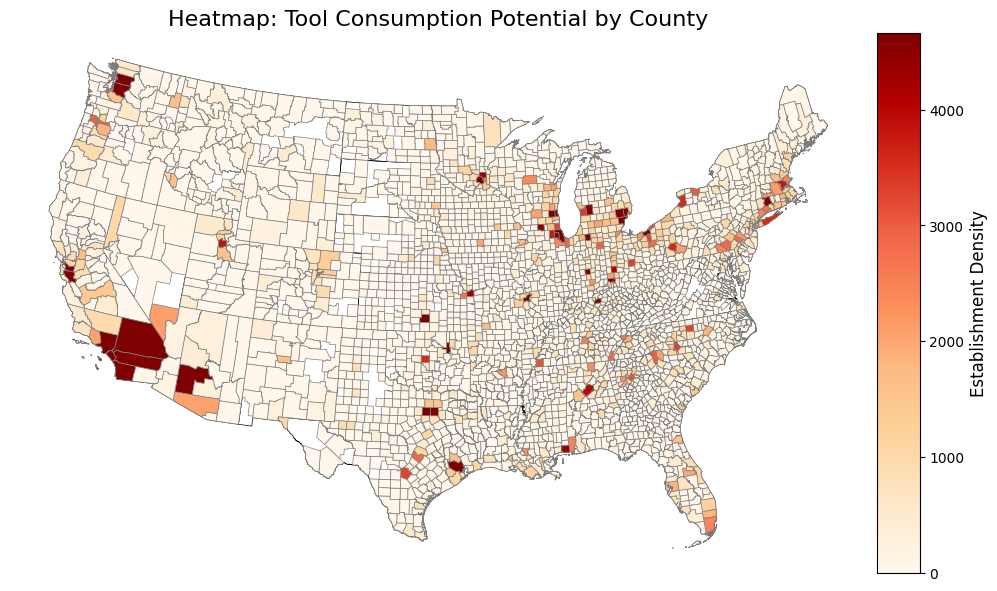

In [ ]:
gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_3327'] +
    gdf_cluster['est_3320A2'] +
    gdf_cluster['est_3320A1'] +
    gdf_cluster['est_3335'] +
    gdf_cluster['est_3315'] +
    gdf_cluster['emp_occ_51-4041'] +
    gdf_cluster['emp_occ_51-4121'] +
    gdf_cluster['emp_occ_51-4031'] +
    gdf_cluster['emp_occ_47-2211'] +
    gdf_cluster['emp_occ_51-4033']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['total_est'].quantile(0.01)
vmax = gdf_cluster['total_est'].quantile(0.99)

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

heatmap = gdf_cluster.plot(
    column='total_est',
    cmap='OrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='0.5',
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax
)

cax.set_ylabel('Establishment Density', fontsize=12)

ax.set_title('Heatmap: Tool Consumption Potential by County', fontsize=16)
ax.set_axis_off()

plt.show()


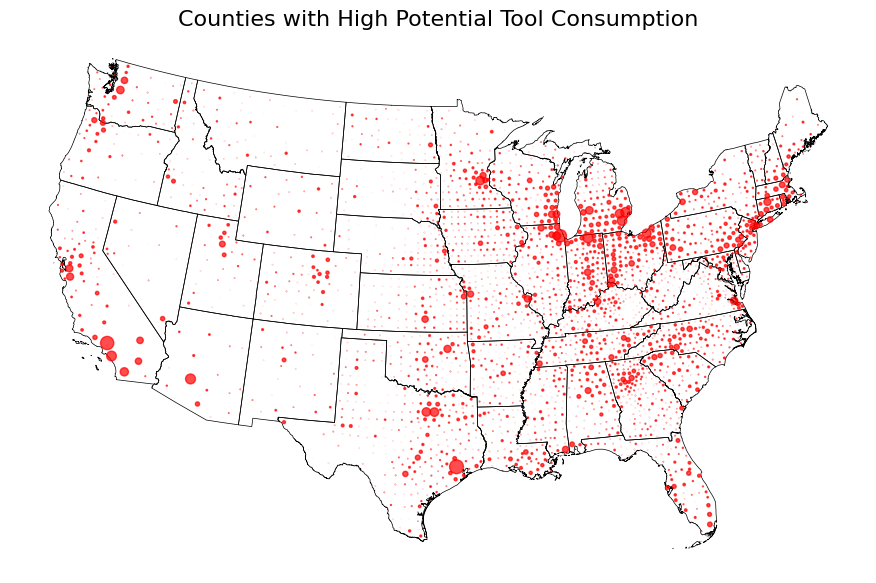

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_3327'] +
    gdf_cluster['est_3320A2'] +
    gdf_cluster['est_3320A1'] +
    gdf_cluster['est_3335'] +
    gdf_cluster['est_3315'] +
    gdf_cluster['emp_occ_51-4041'] +
    gdf_cluster['emp_occ_51-4121'] +
    gdf_cluster['emp_occ_51-4031'] +
    gdf_cluster['emp_occ_47-2211'] +
    gdf_cluster['emp_occ_51-4033']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 7))

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

gdf_cluster.set_geometry('centroid').plot(
    ax=ax,
    color='red',
    markersize=gdf_cluster['total_est'] / gdf_cluster['total_est'].max() * 100,
    alpha=0.7
)

ax.set_title('Counties with High Potential Tool Consumption', fontsize=16)
ax.set_axis_off()

plt.show()


In [ ]:
image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.

1. Unique FIPS mit ins clustering und gewichten
2. Alle Cluster auf der Map darstellen
3. Nach dem Log Scaling nochmal Normalisieren
4. Ist cluster -1 sinnvoll?
5. Alle Occupations machen